In [1]:
# Load relevant modules

import numpy as np
import matplotlib.pyplot as plt

from scipy.integrate import quad

# Problem 1

<ipython-input-2-e34bb751fc88>:65: RuntimeWarning: invalid value encountered in true_divide
  return (9*10**9)*q/2 * (z - R*x)/((R**2 + z**2 - 2*R*z*x)**(3/2))  # integrate along dx
<ipython-input-2-e34bb751fc88>:133: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  res = quad(fun, xmin, xmax, args=(c))


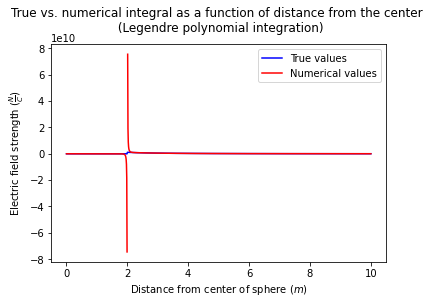

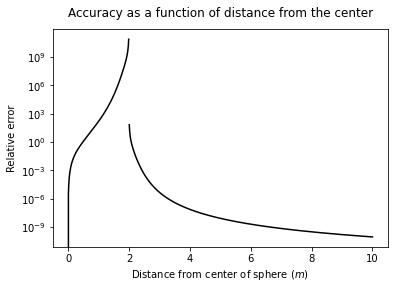

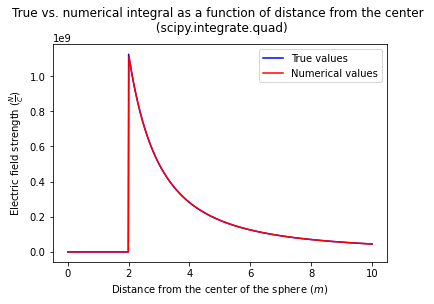

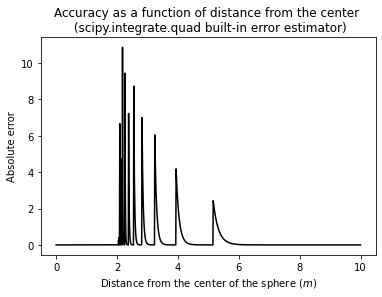

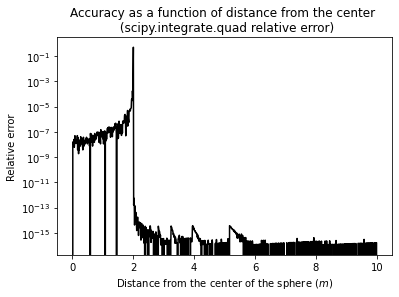

In [2]:
# For problem 1, use Legendre Polynomials to integrate


# --------------------------- Define a bunch of functions ---------------------------------
 
    
def legendre_mat(npt):
    ''' From PHYS 512 Lecture 3 '''
    x = np.linspace(-1,1,npt)  # Generate x-array
    mat = np.zeros([npt,npt])  # Empty square matrix
    mat[:,0] = 1.0  # First column is P0 = 1
    mat[:,1] = x  # Second column is P1 = x
    
    if npt > 2:
        for i in range(1, npt-1):
            mat[:,i+1] = ((2.0*i+1) * x * mat[:,i] - i*mat[:,i-1])/(i + 1.0)  # Recursion relation for Legendre polynomials
            
    return mat


def integration_coeffs_legendre(npt):
    ''' From Lecture 3 '''
    mat = legendre_mat(npt)
    mat_inv = np.linalg.inv(mat)
    coeffs = mat_inv[0,:]  # First row of P^-1
    coeffs = coeffs/coeffs.sum()*(npt-1.0)  # This is c0
    return coeffs


def integrate(fun, z, xmin, xmax, dx_targ, order=2, verbose=False):
    ''' From Lecture 3 '''
    
    coeffs = integration_coeffs_legendre(order+1)  # Grab Legendre coefficients
    
    if verbose:
        print("fraction difference between first/last coefficients is:", repr(coeffs[0]/coeffs[-1]-1))
    
    npt = int((xmax-xmin)/dx_targ)+1  # Get total number of points
    nn = (npt-1)%(order)
    
    if nn > 0:
        npt = npt+(order-nn)
    assert(npt%(order)==1)
    
    x = np.linspace(xmin, xmax, npt)
    dx = np.median(np.diff(x))
    dat = fun(x, z)  # y-data
    
    mat = np.reshape(dat[:-1],[int((npt-1)/(order)),order]).copy()  # Reshape data to avoid for loop (turn it into a matrix)
    mat[0,0] = mat[0,0] + dat[-1]  # Add last point to the first (because it only appears once)
    mat[1:,0] = 2*mat[1:,0]  # Double everything in the first column
    
    vec = np.sum(mat, axis=0)  # Sum along the columns
    tot = np.sum(vec*coeffs[:-1])*dx
    
    return tot


# ----------------------------------- Define the integrand and the true integral -----------------------------------


def field_integrand(x, z, R=2, q=1/2):
    ''' Define the integrand for the electric field due to a thin spherical shell. '''
    
    return (9*10**9)*q/2 * (z - R*x)/((R**2 + z**2 - 2*R*z*x)**(3/2))  # integrate along dx



def true_integral(z, R=2, q=1/2):
    ''' The real answer the integral of the above function.'''
    
    if z < R:
        return 0.0
    
    return (9*10**9) * q/(z**2)
            

# ------------------------------- Test it out! --------------------------------------------------------------------


fun = field_integrand
z = np.linspace(0, 10, 1001)
xmin = -1
xmax = 1
dx_targ = 0.01
order = 2

true_values = []
numerical_values = []
relative_error = []

for i in z:
    
    true_value = true_integral(i)
    num_value = integrate(fun, i, xmin, xmax, dx_targ, order)
    
    true_values.append(true_value)
    numerical_values.append(num_value)
    relative_error.append(np.abs(true_value-num_value)/(true_value+1))
    
    
# Plots
    
plt.figure(0)
plt.plot(z, true_values, color='blue', label="True values")
plt.plot(z, numerical_values, color='red', label="Numerical values")
plt.ylabel(r"Electric field strength ($\frac{N}{C}$)")
plt.xlabel(r"Distance from center of sphere ($m$)")
plt.title("True vs. numerical integral as a function of distance from the center \n (Legendre polynomial integration)", y=1.03)
#plt.ylim(-1e9,1.5e9)
#plt.yscale("symlog")
plt.legend()
#plt.savefig("true_vs_num_ylim.png", dpi=500, bbox_inches='tight')

plt.figure(1)
plt.plot(z, relative_error, color='k')
plt.yscale("log")
plt.ylabel("Relative error")
plt.xlabel(r"Distance from center of sphere ($m$)")
plt.title("Accuracy as a function of distance from the center", y=1.03)
#plt.savefig("accuracy.png", dpi=500, bbox_inches='tight')


# ------------------------- Now do the same thing but with scipy.integrate.quad -------------------------------------


numerical_quad = []
abserr = []
relative_quad = []

for i,c in enumerate(z):
    
    res = quad(fun, xmin, xmax, args=(c))
    
    numerical_quad.append(res[0])
    abserr.append(res[1])
    relative_quad.append(np.abs(res[0]-true_values[i])/(true_values[i]+1))
    
    
# Plots
    
plt.figure(2)
plt.plot(z, true_values, color='blue', label='True values')
plt.plot(z, numerical_quad, color='red', label='Numerical values')
plt.xlabel(r"Distance from the center of the sphere ($m$)")
plt.ylabel(r"Electric field strength ($\frac{N}{C}$)")
plt.title("True vs. numerical integral as a function of distance from the center \n (scipy.integrate.quad)", y=1.03)
plt.legend()
#plt.savefig("true_vs_num_scipy.png", dpi=500, bbox_inches='tight')

plt.figure(3)
plt.plot(z, abserr, color='k')
plt.xlabel(r"Distance from the center of the sphere ($m$)")
plt.ylabel("Absolute error")
plt.title("Accuracy as a function of distance from the center \n (scipy.integrate.quad built-in error estimator)")
#plt.savefig("accuracy_scipy_builtin.png", dpi=500, bbox_inches='tight')

plt.figure(4)
plt.plot(z, relative_quad, color='k')
plt.xlabel(r"Distance from the center of the sphere ($m$)")
plt.ylabel("Relative error")
plt.title("Accuracy as a function of distance from the center \n (scipy.integrate.quad relative error)")
plt.yscale("log")
#plt.savefig("accuracy_scipy.png",dpi=500, bbox_inches='tight')

plt.show()

# Problem 2

In [3]:

def integrate_adaptive(fun, a, b, tol, extra=None):
    ''' Use Simpson's method '''

    x = np.linspace(a, b, 5)
    
    if not extra:  # Take into account extra information
        y1,y2,y3,y4,y5 = fun(x)  # First time around: generate all data points
        
    else:
        y1,y3,y5 = extra  # The first, middle, and last points have been saved
        y2,y4 = fun(x[1]),fun(x[3])

    dx = (b-a)/(len(x)-1)
    
    area1 = 2*dx*(y1 + 4*y3 + y5)/3 #coarse step
    area2 = dx*(y1 + 4*y2 + 2*y3 + 4*y4 + y5)/3 #finer step
    
    err = np.abs(area1 - area2)
 
    if err < tol:
        return area2
    
    else:
        mid = (a+b)/2
        left = integrate_adaptive(fun, a, mid, tol/2, extra=(y1,y2,y3))  # Save first three points
        right = integrate_adaptive(fun, mid, b, tol/2, extra=(y3,y4,y5))  # Save final three points
        return left+right
    
    
# Test it out!

my_integral = integrate_adaptive(np.exp, -2, 2, 1e-10)
true_integral = np.e**2 - np.e**(-2)

print(np.abs(my_integral - true_integral))

1.979749697511579e-12


# Problem 3

Text(0.5, 1.03, 'Chebishev residuals for natural logarithm approximation')

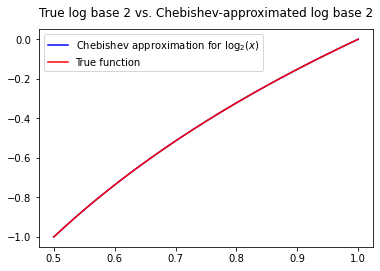

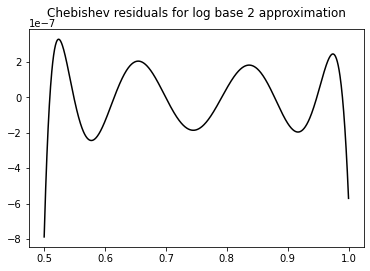

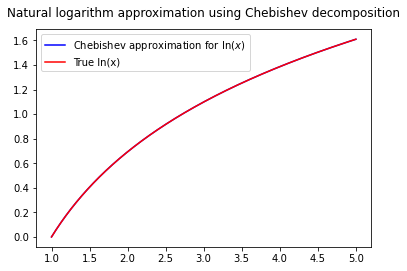

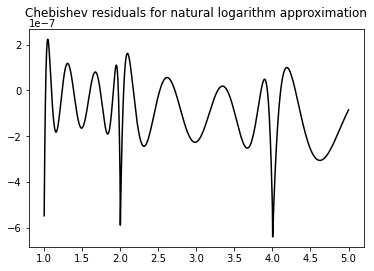

In [4]:
import numpy.polynomial.chebyshev as cheb

deg = 7

x = np.linspace(0.5, 1, 1000)  # Specify range
y_true = np.log2(x)  # True log_2 function

chebishev = cheb.chebfit(x, y_true, deg)  # Get Chebishev coefficients
y_cheb = cheb.chebval(x, chebishev)  # Evaluate the function using Chebishev approximation

plt.figure(0)
plt.plot(x, y_cheb, color='blue', label=r'Chebishev approximation for $\log_2(x)$')
plt.plot(x, y_true, color='red', label='True function')
plt.title("True log base 2 vs. Chebishev-approximated log base 2", y=1.03)
plt.legend()
#plt.savefig("cheb_log2.png", dpi=500, bbox_inches='tight')

residuals = y_true - y_cheb

plt.figure(1)
plt.plot(x, residuals, color='k')
plt.title("Chebishev residuals for log base 2 approximation", y=1.03)
#plt.savefig("cheb_log2_res.png", dpi=500, bbox_inches='tight')

# For log_2(x), the Chebishev approximation is very good with only 8 coefficients! Now for the natural log...

def mylog2(x, coeffs):
    ''' Takes natural logarithm of x assuming I can take the log base 2 of any number between -1 and 1 using my
    Chebishev approximation
    
    Takes as input x, the values I want to take the natural log of, and coeffs, the Chebyshev coefficients'''
    
    
    mantissa, exponent = np.frexp(x)  # Mantissa is always between -1 and 1
    
    # The log base 2 is log_2(x) = log_2(mantissa * 2**exponent) = log_2(mantissa) + exponent
    
    log2 = cheb.chebval(mantissa, coeffs) + exponent  # Approximate the log_2, then add exponent
    
    # Natural log is ln(x) = log_2(x)/log_2(e)
    # log_2(e) is hard because e not in [-1,1], so I will also decompose it into mantissa, exponent
    
    mantissa_e, exponent_e = np.frexp(np.e)
    
    log2e = cheb.chebval(mantissa_e, coeffs) + exponent_e
    
    ln = log2/log2e
    
    return ln

# Test it out!

new_x = np.linspace(1, 5, 1000)  # Pick a random range to test it out on

ln_x = mylog2(new_x, chebishev)

plt.figure(2)
plt.plot(new_x, ln_x, color='blue', label=r"Chebishev approximation for $\ln(x)$")
plt.plot(new_x, np.log(new_x), color='red', label="True ln(x)")
plt.title("Natural logarithm approximation using Chebishev decomposition", y=1.03)
plt.legend()
#plt.savefig("cheb_ln.png", dpi=500, bbox_inches='tight')

plt.figure(3)
plt.plot(new_x, np.log(new_x) - ln_x, color='k')
plt.title("Chebishev residuals for natural logarithm approximation", y=1.03)
#plt.savefig("cheb_ln_res.png", dpi=500, bbox_inches='tight')
